# Data Wrangling - We Rate Dogs 

### Table of Contents
* Introduction
* Gathering
* Assessing
* Cleaning
* Storing
* Analysing

# Introduction

Real world data often does not come clean. Using Python and its libraries, we will gather data from a variety of sources and in different formats, assess it's tidiness and quality, and then clean it. This is called "Data Wrangling". 

By documenting my wrangling efforts in a Jupyter Notebook, i will showcase results by analyses and visualizations using Python and its libraries.

The dataset that i wil be wrangling, analyzing and visualizing is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs, which is a Twitter account that rates people's dogs.

In [1]:
# Import the needed libraries
import pandas as pd
import numpy as np
import requests
import os
import json
import tweepy
import matplotlib.pyplot as plt

## Gather Data
We will gather three pieces of data here:
* The WeRateDogs Twitter archive, which was given by Udacity
* The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
* Each tweet's retweet count and favorite count. Using the tweet IDs in the WeRateDogs Twitter archive, we will query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then the .txt file will be read line by line into a pandas DataFrame with tweet ID, retweet count, and favorite count.

In [2]:
# Read in the provided twitter archive
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
# Programatically download the tweet image predictions
url =  "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
with open(url.split('/')[-1], 'wb') as file:
    file.write(response.content)

In [4]:
# Read in the tsv file into the pandas dataframe
image_predictions = pd.read_csv('image-predictions.tsv', sep = '\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## Download Tweet JSON Data
Query the Twitter API using Python's Tweepy Library to get the whole set of JSON data for each of the tweets in the WeRateDgs Twitter archive. Each JSON data is written line by line to a file called tweet_json.txt

In [5]:
# Import necessary libraries
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

In [6]:
"""
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
"""

'\n# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file\n# These are hidden to comply with Twitter\'s API terms and conditions\nconsumer_key = \'HIDDEN\'\nconsumer_secret = \'HIDDEN\'\naccess_token = \'HIDDEN\'\naccess_secret = \'HIDDEN\'\n\nauth = OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n\napi = tweepy.API(auth, wait_on_rate_limit=True)\n\n# Tweet IDs for which to gather additional data via Twitter\'s API\ntweet_ids = twitter_archive.tweet_id.values\nlen(tweet_ids)\n\n# Query Twitter\'s API for JSON data for each tweet ID in the Twitter archive\ncount = 0\nfails_dict = {}\nstart = timer()\n# Save each tweet\'s returned JSON as a new line in a .txt file\nwith open(\'tweet_json.txt\', \'w\') as outfile:\n    # This loop will likely take 20-30 minutes to run because of Twitter\'s rate limit\n    for tweet_id in tweet_ids:\n        count += 1\n        print(str(count) + ": " + str(tweet_id))\n       

In [7]:
with open('tweet-json.txt', encoding = 'utf-8') as file:
    print(len(file.readlines()))

2354


In [8]:
# Create an empty list to load data line by line into it
tweet_list = []

with open('tweet-json.txt', 'r', encoding = 'utf-8') as json_file:
    for line in json_file:
        data = json.loads(line)
        tweet_list.append(data)

In [9]:
# Convert the list to a dataframe and seperate out the variables of interest
df = pd.DataFrame(tweet_list, columns = tweet_list[0].keys())
tweet_data = df[['id', 'retweet_count', 'favorite_count']]

In [10]:
# Check if the extraction was successful
tweet_data.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


# Assessing

After gathering, this is the next step. Here, we will assess the already gathered data visually and programatically to check for tidiness and quality issues.

### 1. Visual Assessment

In [11]:
# Visually assess the twitter archive
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [12]:
# Visually assess the image prediction file
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [13]:
# Visually assess tweet_data
tweet_data

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


### Programatic Assessment

### Twitter_archive
First, we programatically assess twitter_archive

In [14]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
# Check where expanded_urls is null or NaN
twitter_archive[twitter_archive.expanded_urls.isnull() == True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [16]:
# Check for erroneous datatypes
twitter_archive.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [17]:
# Check for unusual statistics and outliers
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [18]:
# Check the observation where the rating denominator is maximum
twitter_archive[twitter_archive.rating_denominator == twitter_archive.rating_denominator.max()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None


In [19]:
# Check the observation where the rating numerator is maximum
twitter_archive[twitter_archive.rating_numerator == twitter_archive.rating_numerator.max()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [20]:
# Check the observation where rating numerator is more than 20
twitter_archive[twitter_archive.rating_numerator > 20]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [21]:
# Check the observation where rating denominator is not 10
twitter_archive[(twitter_archive.rating_denominator > 10) | (twitter_archive.rating_denominator < 10)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [22]:
# Check the text where the numerator values have been entered incorectly
pd.set_option('display.max_colwidth', 500)
twitter_archive[twitter_archive.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


,text,rating_numerator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
1689,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26


In [23]:
# Check for duplicated tweet ids
twitter_archive[twitter_archive.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [24]:
# Check the observations where retweeted_status_id or retweeted status_user_id are not null
twitter_archive[(twitter_archive.retweeted_status_id.isnull() == False) | (twitter_archive.retweeted_status_user_id.isnull() == False)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397445533696/photo/1,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,"https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1",14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" re

In [25]:
# Check the observations where in_reply_to_status or in_reply_to_user_id are not null
twitter_archive[(twitter_archive.in_reply_to_status_id.isnull() == False) | (twitter_archive.in_reply_to_user_id.isnull() == False)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547188785154/photo/1,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610513747968/photo/1,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


### image_predictions
First, we programatically assess image_predictions

In [26]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
# Check for unusual statistics and outliers
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [28]:
image_predictions.sample(50)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1985,872261713294495745,https://pbs.twimg.com/media/DBrlZk2UQAAfAkd.jpg,2,Labrador_retriever,0.972019,True,flat-coated_retriever,0.008178,True,Chesapeake_Bay_retriever,0.007359,True
361,672828477930868736,https://pbs.twimg.com/media/CVZd7ttWcAEs2wP.jpg,1,sandbar,0.118154,False,stingray,0.075915,False,seashore,0.075125,False
448,674690135443775488,https://pbs.twimg.com/media/CVz7FxXWUAAlTRP.jpg,1,tick,0.242538,False,nail,0.212589,False,screw,0.172838,False
1023,710283270106132480,https://pbs.twimg.com/media/Cdtu3WRUkAAsRVx.jpg,2,Shih-Tzu,0.932401,True,Lhasa,0.030806,True,Tibetan_terrier,0.008974,True
225,670338931251150849,https://pbs.twimg.com/media/CU2FsRnVAAA3TEg.jpg,1,cairn,0.245033,True,West_Highland_white_terrier,0.137709,True,miniature_schnauzer,0.089173,True
101,667793409583771648,https://pbs.twimg.com/media/CUR6jqVWsAEgGot.jpg,1,dalmatian,0.535073,True,English_setter,0.451219,True,Great_Dane,0.008164,True
1098,720389942216527872,https://pbs.twimg.com/media/Cf9W1J-UMAErahM.jpg,1,Pembroke,0.873977,True,Cardigan,0.043339,True,Eskimo_dog,0.019197,True
112,667911425562669056,https://pbs.twimg.com/media/CUTl5m1WUAAabZG.jpg,1,frilled_lizard,0.257695,False,ox,0.235160,False,triceratops,0.085317,False
879,698549713696649216,https://pbs.twimg.com/media/CbG_QRJXEAALVWy.jpg,1,French_bulldog,0.998544,True,Boston_bull,0.001404,True,boxer,0.000023,True
1519,787717603741622272,https://pbs.twimg.com/media/Cu6I9vvWIAAZG0a.jpg,3,German_shepherd,0.992339,True,malinois,0.004920,True,kelpie,0.000853,True


In [29]:
# Check where the p1_conf observations = 1
image_predictions[image_predictions.p1_conf == 1.0]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
106,667866724293877760,https://pbs.twimg.com/media/CUS9PlUWwAANeAD.jpg,1,jigsaw_puzzle,1.0,False,prayer_rug,1.011300e-08,False,doormat,1.740170e-10,False


In [30]:
# Check the distribution of img_num values
image_predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [31]:
# Check for duplicated tweet ids
image_predictions[image_predictions.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [32]:
# Check for duplicated jpg_url
image_predictions[image_predictions.jpg_url.duplicated()].jpg_url.values

array([ 'https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg',
       'https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg',
       'https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg',
       'https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg',
       'https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg',
       'https://pbs.twimg.com/tweet_video_thumb/CeBym7oXEAEWbEg.jpg',
       'https://pbs.twimg.com/media/CYLDikFWEAAIy1y.jpg',
       'https://pbs.twimg.com/media/ChK1tdBWwAQ1flD.jpg',
       'https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg',
       'https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg',
       'https://pbs.twimg.com/media/Cp6db4-XYAAMmqL.jpg',
       'https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg',
       'https://pbs.twimg.com/media/CW88XN4WsAAlo8r.jpg',
       'https://pbs.twimg.com/media/CmoPdmHW8AAi8BI.jpg',
       'https://pbs.twimg.com/media/CcG07BYW0AErrC9.jpg',
       'https://pbs.twimg.com/media/Ck2d7tJWUAEPTL3.jpg',
       'https://pbs

In [33]:
# Check for all the duplicates of jpg_url
image_predictions[image_predictions.jpg_url.apply(lambda x: x in image_predictions[image_predictions.jpg_url.duplicated()].jpg_url.values)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
85,667509364010450944,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,1,beagle,0.636169,True,Labrador_retriever,0.119256,True,golden_retriever,0.082549,True
224,670319130621435904,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
241,670444955656130560,https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg,1,English_springer,0.403698,True,Brittany_spaniel,0.347609,True,Welsh_springer_spaniel,0.137186,True
327,671896809300709376,https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg,1,chow,0.243529,True,hamster,0.227150,False,Pomeranian,0.056057,True
382,673320132811366400,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True
432,674291837063053312,https://pbs.twimg.com/media/CVuQ2LeUsAAIe3s.jpg,1,Cardigan,0.611525,True,Pembroke,0.368566,True,Chihuahua,0.003330,True
480,675354435921575936,https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
487,675501075957489664,https://pbs.twimg.com/media/CV_cnjHWUAADc-c.jpg,1,dough,0.806757,False,bakery,0.027907,False,French_loaf,0.018189,False
587,679062614270468097,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
591,679158373988876288,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False


### Tweet_data
First, we programatically assess tweet_data

In [34]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [35]:
# Check for unusual statistics and outliers
tweet_data.describe()

,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [36]:
# Check for duplicated ids
tweet_data[tweet_data.id.duplicated()]

,id,retweet_count,favorite_count


In [37]:
# Check for duplicated observations
tweet_data[tweet_data.duplicated() == True]

,id,retweet_count,favorite_count


In [38]:
# Check for the observations where retweet_count and favorite count are duplicated together
tweet_data[(tweet_data.retweet_count.duplicated()) & (tweet_data.favorite_count.duplicated())]

,id,retweet_count,favorite_count
444,819227688460238848,7733,25652
487,813944609378369540,3732,0
715,783821107061198850,2269,8209
740,780496263422808064,4319,0
812,771102124360998913,1663,6898
827,768909767477751808,3129,0
845,766078092750233600,2970,0
860,762699858130116608,4190,13518
883,760153949710192640,38,0
914,756998049151549440,2271,6923


Below are the Quality and Tidiness issues:

## Quality

### twitter_archive

* Missing values in the following columns: in_reply_to_status_id, in_reply_user_id, retweeted_status_id, retweeted_status_user_id, expanded_urls, timestamp
* Erroneous data types - in_reply_to_status_id, in_reply_user_id, retweeted_status_id, retweeted_status_user_id, tweet_id columns(should be str), timestamp and retweeted_status_timestamp columns(need to be split into data and time), dog stage column (should be categorical)
* Some exceptional high values in rating_numerator column, leading to high rating which might be inaccurate
* Rating_denominator other than the standard value of 10
* Some names in the name column are invalid data such as: quite, a, an, such..
* There are six incorrectly entered rating_numerator values.

### image_predictions

* Column names are not descriptive enough
* Use of _ instead of space in p1, p2, p3 column values.
* Values are sometimes uppercase and other times lowercase in p1, p2, p3 columns
* Image duplicate predictions present for jpg_url with different tweet ids and other data the same

### Tweet_data

* Tweet id title is different in different tables. id here, tweet_id in others

## Tidiness

### Twitter_archive

* One variable in 4 columns (doggo, floofer, pupper, puppo)
* merge the tables twitter_archive and tweet_data

## Cleaning

We will work through the cleaning process in three steps:

* Define
* Code
* Test

### Missing Data

In [39]:
# Create copies of the above three dataframes
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
tweet_data_clean = tweet_data.copy()

#### Define:
Remove unnecessary columns: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_user_id, retweeted_status_timestamp.
Fill in the missing values of expanded_urls column in twitter_archive_clean table using tweet_id

#### Code

In [40]:
# Drop the extranneous columns
twitter_archive_clean = twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1)

In [41]:
twitter_archive_clean.expanded_urls = 'https://twitter.com/dog_rates/status/' + twitter_archive_clean.tweet_id.astype(str)

#### Test

In [42]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id               2356 non-null int64
timestamp              2356 non-null object
source                 2356 non-null object
text                   2356 non-null object
retweeted_status_id    181 non-null float64
expanded_urls          2356 non-null object
rating_numerator       2356 non-null int64
rating_denominator     2356 non-null int64
name                   2356 non-null object
doggo                  2356 non-null object
floofer                2356 non-null object
pupper                 2356 non-null object
puppo                  2356 non-null object
dtypes: float64(1), int64(3), object(9)
memory usage: 239.4+ KB


In [43]:
twitter_archive_clean[twitter_archive_clean.expanded_urls.isnull() == True]

,tweet_id,timestamp,source,text,retweeted_status_id,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## Tidiness

1. One variable in 4 columns: dog_stage(doggo, floofer, pupper, puppo)

#### Define: 
Combine the doggo, floofer, pupper and puppo columns into one column - dog_status and drop the unnecessary columns after the combination.

#### Code

#### Test

In [44]:
# Replace the NaNs with empty string
twitter_archive_clean[['doggo', 'floofer', 'pupper', 'puppo']] = twitter_archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].replace('None', '')

In [45]:
# Combine the 4 columns into 1
twitter_archive_clean['dog_status'] = twitter_archive_clean['doggo'] + twitter_archive_clean['floofer'] + twitter_archive_clean['pupper'] + twitter_archive_clean['puppo']

In [46]:
# Drop unnecessary columns
twitter_archive_clean = twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1)

In [47]:
twitter_archive_clean.dog_status.value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggofloofer       1
doggopuppo         1
Name: dog_status, dtype: int64

In [48]:
twitter_archive_clean.dog_status = twitter_archive_clean.dog_status.replace('doggopupper', 'multiple')
twitter_archive_clean.dog_status = twitter_archive_clean.dog_status.replace('doggopuppo', 'multiple')
twitter_archive_clean.dog_status = twitter_archive_clean.dog_status.replace('doggofloofer', 'multiple')

#### Test

In [49]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id               2356 non-null int64
timestamp              2356 non-null object
source                 2356 non-null object
text                   2356 non-null object
retweeted_status_id    181 non-null float64
expanded_urls          2356 non-null object
rating_numerator       2356 non-null int64
rating_denominator     2356 non-null int64
name                   2356 non-null object
dog_status             2356 non-null object
dtypes: float64(1), int64(3), object(6)
memory usage: 184.1+ KB


In [50]:
twitter_archive_clean.dog_status.value_counts()

            1976
pupper       245
doggo         83
puppo         29
multiple      14
floofer        9
Name: dog_status, dtype: int64

2. Tweet id title is different, id here, tweet_id in others

#### Define:
Rename the id column in tweet_data_clean to tweet_id

#### Code

In [51]:
tweet_data_clean = tweet_data_clean.rename(columns = {'id': 'tweet_id'})

#### Test

In [52]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


4. Merge the twitter_archive and tweet_data tables

#### Define:
Merge the tables twitter_archive_clean and tweet_data_clean on tweet_id column

#### Code

In [53]:
twitter_archive_clean = pd.merge(twitter_archive_clean, tweet_data_clean, on = 'tweet_id', how = 'inner')

#### Test

In [54]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 0 to 2353
Data columns (total 12 columns):
tweet_id               2354 non-null int64
timestamp              2354 non-null object
source                 2354 non-null object
text                   2354 non-null object
retweeted_status_id    179 non-null float64
expanded_urls          2354 non-null object
rating_numerator       2354 non-null int64
rating_denominator     2354 non-null int64
name                   2354 non-null object
dog_status             2354 non-null object
retweet_count          2354 non-null int64
favorite_count         2354 non-null int64
dtypes: float64(1), int64(5), object(6)
memory usage: 239.1+ KB


## Quality Issues

### twitter_archive_clean table

1. Erroneous data types: - in_reply_to_status_id, in_reply_user_id, retweeted_status_id, retweeted_status_user_id, tweet_id columns(should be str), timestamp and retweeted_status_timestamp columns(need to be split into data and time), dog stage column (should be categorical)

#### Define:
Change the datatype of timestamp to datetime and remove the observations where tweet_id matches retweeted_status_id

#### Code

In [55]:
# Convert timestamp datatype to datetime
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp)

In [56]:
# Separate out the series of retweeted_status_id to remove later
retweet_clean = twitter_archive_clean.retweeted_status_id

retweet_clean = retweet_clean.dropna()

retweet_clean = retweet_clean.astype('int64')

In [57]:
# Drop the observations where tweet_id matches the retweeted_status_id separated above
twitter_archive_clean = twitter_archive_clean.drop(twitter_archive_clean[twitter_archive_clean.tweet_id.apply(lambda x: x in retweet_clean.values)].index.values, axis = 0)

In [58]:
twitter_archive_clean = twitter_archive_clean.drop('retweeted_status_id', axis = 1)

#### Test

In [59]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2242 entries, 0 to 2353
Data columns (total 11 columns):
tweet_id              2242 non-null int64
timestamp             2242 non-null datetime64[ns]
source                2242 non-null object
text                  2242 non-null object
expanded_urls         2242 non-null object
rating_numerator      2242 non-null int64
rating_denominator    2242 non-null int64
name                  2242 non-null object
dog_status            2242 non-null object
retweet_count         2242 non-null int64
favorite_count        2242 non-null int64
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 210.2+ KB


2. rating_denominator is not the assumed standard value of 10, and there are 6 instances of incorrectly entered rating_numerator values

#### Define:
Correct the observations with incorrect denominators and change the numerator rating accordingly

#### Code

In [60]:
# Check for the instances where rating_denominator is other than 10
pd.set_option('display.max_colwidth', 200)
twitter_archive_clean[['text','expanded_urls', 'rating_numerator', 'rating_denominator']].query('rating_denominator != 10')

,text,expanded_urls,rating_numerator,rating_denominator
312,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",https://twitter.com/dog_rates/status/835246439529840640,960,0
341,@docmisterio account started on 11/15/15,https://twitter.com/dog_rates/status/832088576586297345,11,15
432,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,https://twitter.com/dog_rates/status/820690176645140481,84,70
515,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,https://twitter.com/dog_rates/status/810984652412424192,24,7
783,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",https://twitter.com/dog_rates/status/775096608509886464,9,11
900,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024,165,150
1066,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",https://twitter.com/dog_rates/status/740373189193256964,9,11
1118,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288,204,170
1163,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656,4,20
1200,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801,50,50


In [61]:
# Check the numerator values where they have been incorrectly entered
pd.set_option('display.max_colwidth', 500)
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator', 'rating_denominator']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


,text,rating_numerator,rating_denominator
44,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
339,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
762,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1687,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1710,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


In [62]:
# Replace the incorrect ratings with correct ratings
twitter_archive_clean.loc[783, 'rating_numerator' : 'rating_denominator'] = [14, 10]

twitter_archive_clean.loc[1066, 'rating_numerator' : 'rating_denominator'] = [14, 10]

twitter_archive_clean.loc[1163, 'rating_numerator' : 'rating_denominator'] = [13, 10]

twitter_archive_clean.loc[1200, 'rating_numerator' : 'rating_denominator'] = [11, 10]

twitter_archive_clean.loc[1596, 'rating_numerator' : 'rating_denominator'] = [13, 10]

twitter_archive_clean.loc[1660, 'rating_numerator' : 'rating_denominator'] = [10, 10]

twitter_archive_clean.loc[2333, 'rating_numerator' : 'rating_denominator'] = [9, 10]

twitter_archive_clean.loc[44, 'rating_numerator' : 'rating_denominator'] = [13.50, 10]

twitter_archive_clean.loc[339, 'rating_numerator' : 'rating_denominator'] = [9.75, 10]

twitter_archive_clean.loc[762, 'rating_numerator' : 'rating_denominator'] = [11.27, 10]

twitter_archive_clean.loc[1687, 'rating_numerator' : 'rating_denominator'] = [9.50, 10]

twitter_archive_clean.loc[1710, 'rating_numerator' : 'rating_denominator'] = [11.26, 10]

In [63]:
# Replace the incorrect ratings with correct ratings
twitter_archive_clean[['rating_numerator', 'rating_denominator']] = twitter_archive_clean[['rating_numerator', 'rating_denominator']].replace([960, 0], [13, 10])

In [64]:
# Drop the other wrongly entered ratings
twitter_archive_clean = twitter_archive_clean.drop([341, 515, 783, 1596, 1661], axis = 0)

In [65]:
# Check the datatype of each variable
twitter_archive_clean.dtypes

tweet_id                       int64
timestamp             datetime64[ns]
source                        object
text                          object
expanded_urls                 object
rating_numerator             float64
rating_denominator             int64
name                          object
dog_status                    object
retweet_count                  int64
favorite_count                 int64
dtype: object

In [66]:
# Create a rating_factor column 
twitter_archive_clean['rating_factor'] = twitter_archive_clean.rating_denominator/10

# Change the rating_denominator to 10 and rating_numerator equivalent to 10 using rating_factor variable
twitter_archive_clean.rating_denominator = (twitter_archive_clean.rating_denominator/twitter_archive_clean['rating_factor']).astype('int64')
twitter_archive_clean.rating_numerator = (twitter_archive_clean.rating_numerator/twitter_archive_clean['rating_factor'])

In [67]:
# Drop the rating_factor
twitter_archive_clean.drop('rating_factor', axis=1, inplace=True)

#### Test

In [68]:
twitter_archive_clean.query('rating_denominator != 10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_status,retweet_count,favorite_count


In [69]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237 entries, 0 to 2353
Data columns (total 11 columns):
tweet_id              2237 non-null int64
timestamp             2237 non-null datetime64[ns]
source                2237 non-null object
text                  2237 non-null object
expanded_urls         2237 non-null object
rating_numerator      2237 non-null float64
rating_denominator    2237 non-null int64
name                  2237 non-null object
dog_status            2237 non-null object
retweet_count         2237 non-null int64
favorite_count        2237 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 209.7+ KB


3. Some names in the name column are invalid data such as quite, a, an

#### Define:
Replace all the instances of name column having invalid data with NaN

#### Code

In [70]:
# Check for invalid names
twitter_archive_clean[twitter_archive_clean.name.str.islower() == True].name.value_counts()

a               55
the              8
an               6
very             5
one              4
just             3
quite            3
actually         2
getting          2
not              2
such             1
officially       1
this             1
space            1
all              1
light            1
old              1
my               1
life             1
incredibly       1
mad              1
unacceptable     1
his              1
infuriating      1
by               1
Name: name, dtype: int64

In [71]:
# Replace the invalid names with 'None'
for item in twitter_archive_clean.name:
    if item.islower() == True:
        twitter_archive_clean.name = twitter_archive_clean.name.replace(item, 'None')

In [72]:
# Replace 'None' string with NaN value
twitter_archive_clean.name = twitter_archive_clean.name.replace('None', np.nan)

#### Test

In [73]:
twitter_archive_clean[twitter_archive_clean.name.str.islower() == True].name

Series([], Name: name, dtype: object)

In [74]:
sum(twitter_archive_clean.name.isnull())

810

4. doggo, floofer, pupper and puppo columns have values with the name 'None'

#### Define:
Check for the correct words in the text column to correctly interpret the dog_status and then reform the dog_status using these words

In [75]:
# Check the distribution of each value in the dog_status
twitter_archive_clean.dog_status.value_counts()

            1883
pupper       230
doggo         79
puppo         24
multiple      12
floofer        9
Name: dog_status, dtype: int64

In [76]:
# Take the sample of the data with text and dog_status variables to get an overall idea
pd.set_option('display.max_colwidth', 200)
twitter_archive_clean[['text', 'dog_status']].sample(50)

,text,dog_status
906,RT @dog_rates: This is Chompsky. He lives up to his name. 11/10 https://t.co/Xl37lQEWd0,
2304,These are Peruvian Feldspars. Their names are Cupit and Prencer. Both resemble Rand Paul. Sick outfits 10/10 &amp; 10/10 https://t.co/ZnEMHBsAs1,
1171,This is Derek. He just got balled on. Can't even get up. Poor thing. 10/10 hang in there pupper https://t.co/BIRRF3bcWH,pupper
529,RT @dog_rates: This is Milo. I would do terrible things for Milo. 13/10 https://t.co/R6wJyC2Tey,
1671,This is Todo. He's screaming because he doesn't want to wear his sweater or a seat belt. 9/10 gotta buckle up pup https://t.co/Nm8Spw4HbD,
287,This is Stanley. Somehow he heard you tell him he's a good boy from all the way up there. 13/10 I love you Stanley https://t.co/51FXNuouHI,
2225,Here we have an Azerbaijani Buttermilk named Guss. He sees a demon baby Hitler behind his owner. 10/10 stays alert https://t.co/aeZykWwiJN,
2260,Here is George. George took a selfie of his new man bun and that is downright epic. (Also looks like Rand Paul) 9/10 https://t.co/afRtVsoIIb,
1586,I just love this picture. 12/10 lovely af https://t.co/Kc84eFNhYU,
1442,This is Trevith. He's a Swiss Mountain Roadwoof. Breeze too powerful. 9/10 stay strong pupper https://t.co/6J8Ibwy1X6,pupper


In [77]:
# Collect the correct words for dog_stage interpretation in 4 variables for seperating 4 different dog_stages 
dog_pupper = ['Pup', 'pup', 'pups', 'puppers', 'pupper', 'Pupper', 'puppeters', 'puppy', 'Puppy', 'Pup.', 'pup.', 'pups.', 'puppers.', 'pupper.', 'Pupper.', 'puppeters.', 'puppy.', 'Puppy.', 'pupper,', 'pupper?', '(pupper)', 'PUPPER', '(pupper).']
dog_doggo = ['Doggo', 'doggo', 'dogg', 'Doggo.', 'doggo.', 'dogg.', 'doggo?', '(doggo)', 'DOGGO', '(doggo),']
dog_puppo = ['puppo', 'Puppo', 'puppo.', 'Puppo.', 'puppo?']
dog_floofer = ['Floofer', 'floofs', 'floofer', 'floofers', 'floof', 'Floofy', 'floofy', 'floofs.', 'floofer.', 'floofers.', 'floof.', 'Floofy.', 'floofy.', 'Floofer.']

In [78]:
# Create a new column to test
twitter_archive_clean['dog_status_2'] = ''

In [79]:
# Use the above 4 variables to correctly interpret dog status in the new column
for item in twitter_archive_clean.text:
    y = twitter_archive_clean[twitter_archive_clean.text == item].index.values
    x = str(item).strip(".,").split(' ')
    for word in x:
        if (word in dog_pupper) and (word in dog_doggo):
            twitter_archive_clean.loc[y, 'dog_status_2'] = 'pupper & doggo'
        elif (word in dog_puppo) and (word in dog_doggo):
            twitter_archive_clean.loc[y, 'dog_status_2'] = 'puppo & doggo'
        elif (word in dog_floofer) and (word in dog_doggo):
            twitter_archive_clean.loc[y, 'dog_status_2'] = 'floofer & doggo'
        elif word in dog_pupper:
            twitter_archive_clean.loc[y, 'dog_status_2'] = 'pupper'
        elif word in dog_doggo:
            twitter_archive_clean.loc[y, 'dog_status_2'] = 'doggo'
        elif word in dog_puppo:
            twitter_archive_clean.loc[y, 'dog_status_2'] = 'puppo'
        elif word in dog_floofer:
            twitter_archive_clean.loc[y, 'dog_status_2'] = 'floofer'

In [80]:

# Replace the dog_status column with the new column values
twitter_archive_clean.dog_status = twitter_archive_clean.dog_status_2

In [81]:
# Drop the new column and replace instances of empty string with NaN
twitter_archive_clean.dog_status = twitter_archive_clean.dog_status.replace('', np.nan)
twitter_archive_clean.drop('dog_status_2', axis=1, inplace=True)

#### Test

In [82]:
twitter_archive_clean.dog_status.value_counts()

pupper     413
doggo       79
puppo       23
floofer     20
Name: dog_status, dtype: int64

In [83]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237 entries, 0 to 2353
Data columns (total 11 columns):
tweet_id              2237 non-null int64
timestamp             2237 non-null datetime64[ns]
source                2237 non-null object
text                  2237 non-null object
expanded_urls         2237 non-null object
rating_numerator      2237 non-null float64
rating_denominator    2237 non-null int64
name                  1427 non-null object
dog_status            535 non-null object
retweet_count         2237 non-null int64
favorite_count        2237 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 289.7+ KB


5. Valuues in the source column are not human-readable

#### Define:
Replace the values in the source column to human-readable text

#### Code

In [84]:
# Check the distribution of source values
twitter_archive_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2116
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          80
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

In [85]:
# Replace the values in the source column to human-readable text
twitter_archive_clean.source = twitter_archive_clean.source.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iPhone')
twitter_archive_clean.source = twitter_archive_clean.source.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'Vine - Make a Scene')
twitter_archive_clean.source = twitter_archive_clean.source.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web Client')
twitter_archive_clean.source = twitter_archive_clean.source.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck')

#### Test

In [86]:
twitter_archive_clean.source.value_counts()

Twitter for iPhone     2116
Vine - Make a Scene      80
Twitter Web Client       31
TweetDeck                10
Name: source, dtype: int64

### Image_predictions table

1. Column names are not descriptive enough

#### Define:
Rename the columns to descriptive names

#### Code

In [87]:
image_predictions_clean = image_predictions_clean.rename(columns = {'jpg_url':'image_url', 'img_num':'image_number', 'p1':'first_prediction', 'p2':'second_prediction', 'p3':'third_prediction', 'p1_conf':'first_prediction_confidence', 'p2_conf':'second_prediction_confidence', 'p3_conf':'third_prediction_confidence', 'p1_dog':'first_prediction_dog', 'p2_dog':'second_prediction_dog', 'p3_dog':'third_prediction_dog'})

### Test

In [88]:
list(image_predictions_clean)

['tweet_id',
 'image_url',
 'image_number',
 'first_prediction',
 'first_prediction_confidence',
 'first_prediction_dog',
 'second_prediction',
 'second_prediction_confidence',
 'second_prediction_dog',
 'third_prediction',
 'third_prediction_confidence',
 'third_prediction_dog']

2. Use of _ instead of space for first_prediction, second_prediction, third_prediction columns values. Also, Values are sometimes uppercase and other times lowercase in first_prediction, second_prediction, third_prediction columns.

#### Define:
Replace the '_' with ' ' and change the values to uppercase in p1, p2, p3

#### Code

In [89]:
image_predictions_clean.first_prediction = image_predictions_clean.first_prediction.str.replace('_', ' ').str.capitalize()
image_predictions_clean.second_prediction = image_predictions_clean.second_prediction.str.replace('_', ' ').str.capitalize()
image_predictions_clean.third_prediction = image_predictions_clean.third_prediction.str.replace('_', ' ').str.capitalize()

#### Test

In [90]:
image_predictions_clean[['first_prediction', 'second_prediction', 'third_prediction']].sample(10)

,first_prediction,second_prediction,third_prediction
1947,Basset,Beagle,Boxer
353,Gondola,Lifeboat,Bassinet
205,Car mirror,Seat belt,Wing
1767,Golden retriever,Labrador retriever,Tennis ball
348,Border collie,Collie,Shetland sheepdog
967,Pembroke,Chihuahua,Bloodhound
1573,Golden retriever,Labrador retriever,Tennis ball
1638,Arabian camel,House finch,Cocker spaniel
888,Schipperke,Chesapeake bay retriever,Kelpie
20,Maltese dog,Toy poodle,Miniature poodle


2. Image duplicate predictions present for jpg_url with different tweet ids and the rest of the data the same

#### Define:
Drop all the observations where image_url is duplicated.

#### Code

In [91]:
image_predictions_clean = image_predictions_clean.drop_duplicates(['image_url'])

#### Test

In [92]:
image_predictions_clean[image_predictions_clean.image_url.duplicated()]

,tweet_id,image_url,image_number,first_prediction,first_prediction_confidence,first_prediction_dog,second_prediction,second_prediction_confidence,second_prediction_dog,third_prediction,third_prediction_confidence,third_prediction_dog


In [93]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id                        2009 non-null int64
image_url                       2009 non-null object
image_number                    2009 non-null int64
first_prediction                2009 non-null object
first_prediction_confidence     2009 non-null float64
first_prediction_dog            2009 non-null bool
second_prediction               2009 non-null object
second_prediction_confidence    2009 non-null float64
second_prediction_dog           2009 non-null bool
third_prediction                2009 non-null object
third_prediction_confidence     2009 non-null float64
third_prediction_dog            2009 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 162.8+ KB


## Storing the data

#### 1. Storing twitter_archive_clean

In [94]:
tweet_archive_master = pd.merge(twitter_archive_clean, image_predictions_clean, on = 'tweet_id', how = 'inner')

In [95]:
tweet_archive_master.to_csv('twitter_archive_master.csv')

#### 2. Storing image_predictions_clean

In [96]:
image_predictions_clean.to_csv('image_predictions_master.csv')

## Analysing the data

In [97]:
# Create copy of twitter_archive_clean to work off of using only my variables of interest
time_df = twitter_archive_clean[['timestamp', 'retweet_count', 'favorite_count', 'rating_numerator', 'rating_denominator']].copy()

In [98]:
# Set the index to be the timestamp so time is displayed properly in plots
time_df.set_index('timestamp', inplace=True)

In [99]:
# Create rating_ratio variable by dividing the rating numerator by the denominator to normalize the scores which are not 
# out of 10
time_df['rating_ratio'] = time_df['rating_numerator']/time_df['rating_denominator']

In [100]:
# Import necessary libraries for creating the visuals
import matplotlib.pyplot as plt
import seaborn as sb

% matplotlib inline

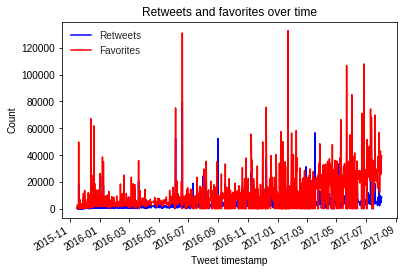

In [101]:
time_df['retweet_count'].plot(color = 'blue', label='Retweets')
time_df['favorite_count'].plot(color = 'red', label='Favorites')
plt.style.use('seaborn-darkgrid')
plt.legend(loc='upper left')
plt.xlabel('Tweet timestamp')
plt.ylabel('Count')
plt.title('Retweets and favorites over time')
plt.savefig('retweets_favorites.png')
plt.show()

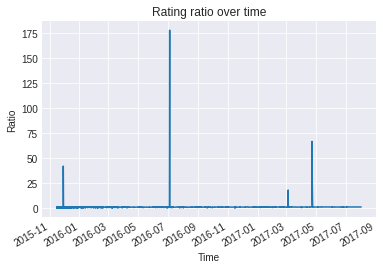

In [102]:
time_df['rating_ratio'].plot()
plt.style.use('seaborn-darkgrid')
plt.xlabel('Time')
plt.ylabel('Ratio')
plt.title('Rating ratio over time')
plt.savefig('ratio.png')
plt.show()

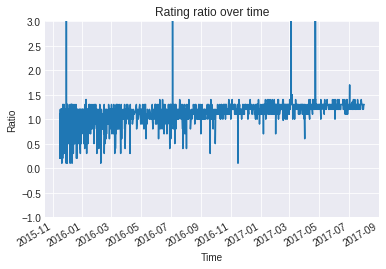

In [103]:
# Limit y axis to zoom in on data and ignore outliers
time_df['rating_ratio'].plot()
plt.ylim(-1, 3)
plt.style.use('seaborn-darkgrid')
plt.xlabel('Time')
plt.ylabel('Ratio')
plt.title('Rating ratio over time')
plt.savefig('ratio_zoom.png')
plt.show()